In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import factorial, hermitenorm
from numba import njit

In [2]:
@njit
def ode(u, t, a=1):
    return -0.5 * u**2 + (a+1) * u

@njit
def ode_book(u,t, a=1):
    return -a*u

@njit
def fact(x):
    '''
    calculates factorial

    Arguments:
        x -- integer

    Returns:
        x!
    '''
    factors = np.arange(1,x+1)
    y = 1
    for i in range(x):
        y = y * factors[i]
    return y

@njit
def e_ijk(i,j,k):
    s = np.ceil((i+j+k)/2)
    return (fact(i)*fact(j)*fact(k)) / (fact(s-i)*fact(s-j)*fact(s-k))

@njit
def get_A(N, mu, sigma):
    A = np.zeros((N,N))
    a = np.array([mu, sigma])

    for j in range(N):
        for k in range(N):
            Ajk = 0
            for i, ai in enumerate(a):
                Ajk += ai * e_ijk(i,j,k)
            A[j,k] = -1/fact(k) * Ajk
    
    return A

@njit
def get_A_book(N, mu, sigma):
    A = np.zeros((N,N))
    a = np.array([mu, sigma])

    for j in range(N):
        for k in range(N):
            Ajk = 0
            for i, ai in enumerate(a):
                Ajk += ai * e_ijk(i,j,k)
            A[j,k] = -1/fact(k) * Ajk
    return A

@njit
def get_b_book(N, betha):
    b = np.zeros(N)
    b[0] = betha
    return b

def get_vhats_book(N, mu, sigma, betha):
    A = get_A_book(N,mu,sigma)
    b = get_b_book(N,betha)
    vhats = np.linalg.solve(A.T,b)

    return vhats

def approx_book(t, vhats):
    u = 0
    for i, vhat in enumerate(vhats):
        u += vhat * hermitenorm(i)(t)
    return u



In [3]:
u0 = 0.1 # initial condition

In [19]:
N = 1000
dudt2s_mean = []
for i in range(100):
    dudt2s = np.zeros(N)
    for i in range(N):
        a = np.random.normal(0,1)
        dudt2s[i] = solve_ivp(ode_book, (0,2), [u0], args = (a,)).y[0,-1]
    dudt2s_mean.append(np.mean(dudt2s))

In [20]:
print(np.mean(dudt2s))
print(np.var(dudt2s))

0.13722318317967233
3.7172485471620034


In [21]:
vhats = get_vhats_book(3,0,1,0.1)

In [22]:
t = np.linspace(0,2,101)
app = approx_book(t, vhats)

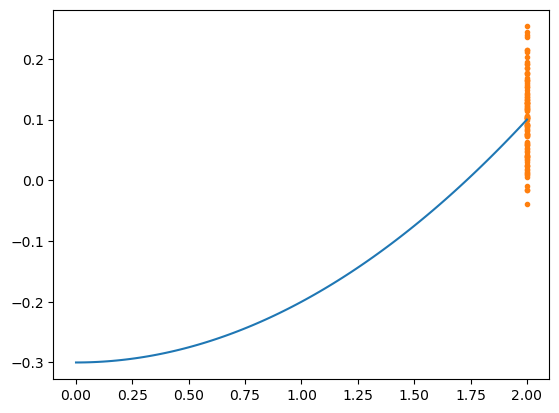

In [23]:
plt.plot(t, app)
plt.scatter(2*np.ones_like(dudt2s_mean), dudt2s_mean, marker='.', color = 'C1')